# IONQ Thruster 

In [29]:
# Import the necessary libraries
import os
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_ionq import IonQProvider

In [30]:
# Initialize the IonQ provider and backend
api_key = os.getenv("IONQ_API_KEY") or input("Enter your IonQ API key: ")
provider = IonQProvider(token=api_key)
backend = provider.get_backend("simulator", gateset="native")

In [31]:
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.dagcircuit import DAGCircuit
from qiskit.dagcircuit.dagnode import DAGOpNode

class GPI2_Adjoint(TransformationPass):
    
    def run(self, dag: DAGCircuit) -> DAGCircuit:
        nodes_to_remove = []

        for node in dag.op_nodes(): 
            if isinstance(node, DAGOpNode) and node.op.name == 'gpi2':
                successors = [succ for succ in dag.quantum_successors(node) if isinstance(succ, DAGOpNode)]  
                for next_node in successors:
                    if next_node.op.name == 'gpi2':
                        # Check if they cancel each other out
                        phi1 = node.op.params[0]
                        phi2 = next_node.op.params[0]
                        if (phi2 + 0.5) % 1 == phi1 % 1 or (phi1 + 0.5) % 1 == phi2 % 1:
                            # Mark both nodes for removal
                            nodes_to_remove.extend([node, next_node])

        for node in nodes_to_remove:
            dag.remove_op_node(node)
        
        return dag
    
class GPI_Adjoint(TransformationPass):
    
    def run(self, dag: DAGCircuit) -> DAGCircuit:
        nodes_to_remove = []

        for node in dag.op_nodes(): 
            if isinstance(node, DAGOpNode) and node.op.name == 'gpi':
                successors = [succ for succ in dag.quantum_successors(node) if isinstance(succ, DAGOpNode)]  
                for next_node in successors:
                    if next_node.op.name == 'gpi':
                        # Check if they cancel each other out
                        phi1 = node.op.params[0]
                        phi2 = next_node.op.params[0]
                        if phi2 == phi1:
                            # Mark both nodes for removal
                            nodes_to_remove.extend([node, next_node])

        for node in nodes_to_remove:
            dag.remove_op_node(node)
        
        return dag


class CommuteGPI2MS(TransformationPass):
    def run(self, dag: DAGCircuit) -> DAGCircuit:
        for node in dag.op_nodes():
            if node.op.name == 'gpi2' and node.op.params == [0.5]:  # GPI2(pi/2)
                successors = list(dag.successors(node))
                for next_node in successors:
                    if isinstance(next_node, DAGOpNode) and next_node.op.name == 'ms' and next_node.op.params == [0, 0, 0.25]:
                        # Create a sub-DAG = MS - GPI2
                        sub_dag = DAGCircuit()
                        sub_dag.add_qreg(dag.qregs)
                        #sub_dag.add_creg(dag.cregs)
                        sub_dag.apply_operation_back(next_node.op, next_node.qargs)
                        sub_dag.apply_operation_back(node.op, node.qargs)

                        dag.substitute_node_with_dag(node, sub_dag, wires={q: q for q in dag.qubits})
                        dag.remove_op_node(next_node)
                        break
        return dag

In [14]:
from qiskit import transpile
from qiskit.transpiler import PassManager
from qiskit.converters import dag_to_circuit, circuit_to_dag
from rewrite_rules import GPI2_Adjoint, GPI_Adjoint, CommuteGPI2MS

class IonQ_Transpiler:
    def __init__(self, backend):
        self.backend = backend
        self.pass_manager = self.custom_pass_manager()

    @staticmethod
    def custom_pass_manager():
        pm = PassManager()
        pm.append([
            GPI2_Adjoint(), 
            GPI_Adjoint(), 
            CommuteGPI2MS()
        ])
        return pm

    def transpile(self, qc):
        # Transpile with IBM transpiler first
        ibm_transpiled = transpile(qc, backend=self.backend, optimization_level=3)
        
        # Apply custom optimization passes
        optimized_dag = self.pass_manager.run(circuit_to_dag(ibm_transpiled))
        
        # Convert the optimized DAG back to a QuantumCircuit
        optimized_circuit = dag_to_circuit(optimized_dag)
        
        return optimized_circuit

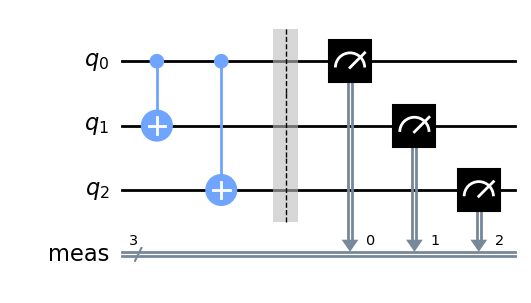

In [32]:
qc = QuantumCircuit(3, name="2cnots")
qc.cx(0, 1)
qc.cx(0, 2)
qc.measure_all()
qc.draw('mpl')


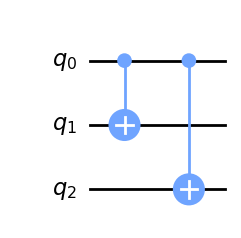

In [33]:
qc.remove_final_measurements()
qc.draw('mpl')

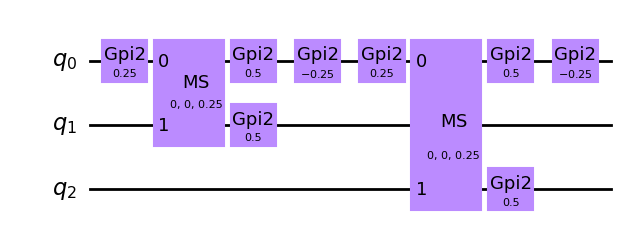

In [34]:
ibm_transpiled = transpile(qc, backend, optimization_level=3)
ibm_transpiled.draw(output='mpl')
#a = pm.run(ibm_transpiled)

In [28]:
transpiler = IonQ_Transpiler(backend)
opt = transpiler.transpile(qc)
opt.draw('mpl')

DAGCircuitError: 'not a QuantumRegister instance.'

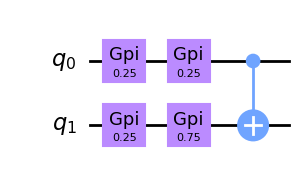

In [15]:
qc = QuantumCircuit(2)
qc.append(GPIGate(0.25), [0])  # GPI2(pi/2)
qc.append(GPIGate(0.25), [0])  # GPI2(3pi/2)
qc.append(GPIGate(0.25), [1])  # GPI2(pi/2)
qc.append(GPIGate(0.75), [1])  # GPI2(3pi/2)
qc.cx(0, 1)

qc.draw(output='mpl')

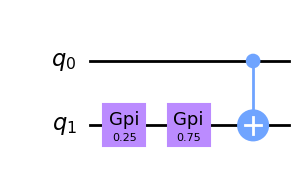

In [16]:
pm.run(qc).draw(output='mpl')

In [17]:
import numpy as np

a = ZZGate(np.pi).__array__
print(a)

<bound method ZZGate.__array__ of Instruction(name='zz', num_qubits=2, num_clbits=0, params=[3.141592653589793])>


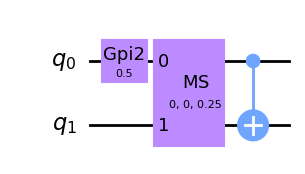

In [227]:
qc3 = QuantumCircuit(2)
qc3.append(GPI2Gate(0.5), [0])  # GPI2(pi)
qc3.append(MSGate(0, 0, 0.25), [0, 1])
qc3.cx(0, 1)

qc3.draw(output='mpl')


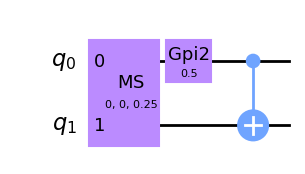

In [228]:
pm.run(qc3).draw(output='mpl')